<a href="https://colab.research.google.com/github/SVJLucas/TrainingSmallVisionLanguageModels/blob/main/code/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [ ]:
import os
import time
import datetime
import requests

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from io import BytesIO
from typing import Tuple, Dict, Any, Optional
from PIL import Image
import random

from sklearn.metrics import f1_score, jaccard_score, accuracy_score

from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence

from transformers import AutoProcessor, AutoModelForZeroShotImageClassification, AutoTokenizer, AutoModelForCausalLM, OPTForCausalLM

# Downloading the Dataset

 Installing Kaggle's package:

In [ ]:
!pip install kaggle

Downloading the data:

In [ ]:
# Set up the Kaggle configuration
import os
import json

# Make directory to store Kaggle API key
os.makedirs('/root/.kaggle/', exist_ok=True)

# Move kaggle.json file to the directory
!mv kaggle.json /root/.kaggle/

# Change the permissions of the file
os.chmod('/root/.kaggle/kaggle.json', 600)

# Download the dataset
!kaggle datasets download -d vikashrajluhaniwal/fashion-images

# Unzip the dataset
!unzip fashion-images.zip

In [ ]:
data = pd.read_csv('data/fashion.csv')
data

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...
...,...,...,...,...,...,...,...,...,...,...
2901,51755,Women,Footwear,Shoes,Casual Shoes,Black,Casual,Catwalk Women Black Shoes,51755.jpg,http://assets.myntassets.com/v1/images/style/p...
2902,47630,Women,Footwear,Shoes,Flats,Blue,Casual,Carlton London Women Blue Shoes,47630.jpg,http://assets.myntassets.com/v1/images/style/p...
2903,32836,Women,Footwear,Shoes,Flats,Pink,Casual,Grendha Women Flori Pink Sandals,32836.jpg,http://assets.myntassets.com/v1/images/style/p...
2904,35821,Women,Footwear,Shoes,Heels,Black,Casual,Enroute Women Black Heels,35821.jpg,http://assets.myntassets.com/v1/images/style/p...


Image name: 43876.jpg
Description: White Casual Casual Shoes for Men - Footwear Shoes <\s>


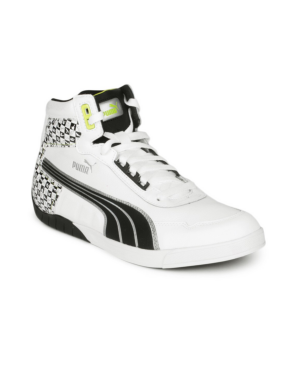






--------------------------------------------------
Image name: 41304.jpg
Description: White Casual Shirts for Boys - Apparel Topwear <\s>


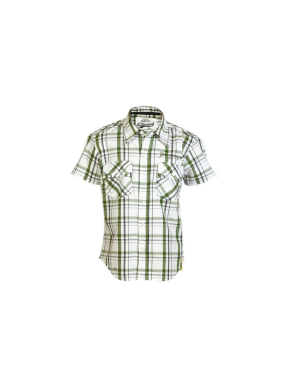






--------------------------------------------------
Image name: 3892.jpg
Description: Pink Casual Tshirts for Girls - Apparel Topwear <\s>


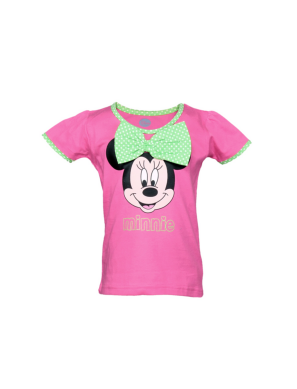






--------------------------------------------------
Image name: 3852.jpg
Description: Pink Casual Tshirts for Girls - Apparel Topwear <\s>


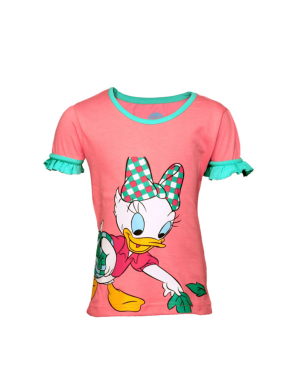






--------------------------------------------------
Image name: 36136.jpg
Description: Green Sports Sports Shoes for Women - Footwear Shoes <\s>


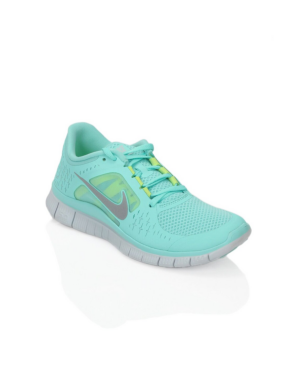






--------------------------------------------------
Image name: 22101.jpg
Description: Grey Casual Casual Shoes for Men - Footwear Shoes <\s>


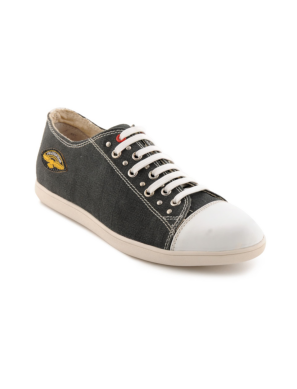






--------------------------------------------------
Image name: 38996.jpg
Description: Blue Casual Jeans for Boys - Apparel Bottomwear <\s>


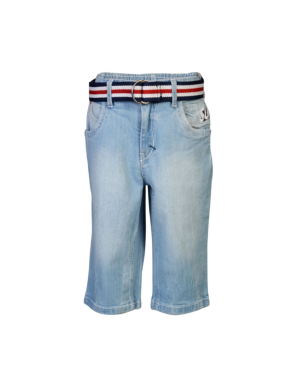






--------------------------------------------------


In [19]:

def load_images_from_directory(directory_path: str) -> dict:
    """
    Loads images from a specified directory and returns a dictionary
    with image names as keys and image objects as values.

    Args:
        directory_path (str): The path to the directory containing images.

    Returns:
        dict: A dictionary with image names as keys and image objects as values.
    """
    image_dict = {}

    # Traverse the directory
    for root, _, files in os.walk(directory_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                # Get the full file path
                file_path = os.path.join(root, file)
                # Open the image
                image = Image.open(file_path)
                # Store in the dictionary
                image_dict[file] = {'image':image}

    return image_dict

# Define the directories
directories = [
    'data/Apparel/Boys/Images/images_with_product_ids',
    'data/Apparel/Girls/Images/images_with_product_ids',
    'data/Footwear/Men/Images/images_with_product_ids',
    'data/Footwear/Women/Images/images_with_product_ids'
]

# Initialize the dictionary to hold all images
all_images = {}

# Load images from each directory and update the main dictionary
for directory in directories:
    images = load_images_from_directory(directory)
    all_images.update(images)

for _, row in data.iterrows():
  description = f"{row['Colour']} {row['Usage']} {row['ProductType']} for {row['Gender']} - {row['Category']} {row['SubCategory']} <\s>"
  all_images[row['Image']]['description'] = description

# Randomly select 7 images from the dictionary
random_images = random.sample(list(all_images.items()), 7)

# Verify the result by displaying some images
for image_name, image in random_images:
    print(f"Image name: {image_name}")
    print(f"Description: {image['description']}")
    plt.imshow(image['image'])
    plt.axis('off')
    plt.show()
    print('\n' * 4)
    print(50 * '-')

# Torch Dataset Class

In [ ]:
def collate_fn(batch):
    """
    Custom collate function to handle variable length sequences in the batch.

    Args:
        batch: A list of tuples (image_embedding, input_ids, attention_mask, labels).

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: Batched image embeddings,
        padded input ids, padded attention masks, padded labels, and original sequence lengths.
    """
    image_embeddings, input_ids, attention_masks, labels = zip(*batch)

    # Stack image embeddings (they are already of the same size)
    image_embeddings = torch.stack(image_embeddings)

    # Pad input ids, attention masks, and labels
    input_lengths = torch.tensor([len(ids) for ids in input_ids])
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    padded_attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # Use -100 to ignore the padding in loss computation

    return image_embeddings, padded_input_ids, padded_attention_masks, padded_labels, input_lengths

class ECommerceDataset(Dataset):
    """
    PyTorch Dataset for apparel images and their descriptions.

    Args:
        data_dict (Dict[str, Dict[str, Any]]): Dictionary containing image filenames as keys and
                   dictionaries with 'image' (PIL Image) and 'description' as values.
        transform (Optional[Any]): Optional transform to be applied on a sample.
    """
    def __init__(self, data_dict: Dict[str, Dict[str, Any]], transform: Optional[Any] = None) -> None:
        self.data_dict = data_dict
        self.transform = transform
        self.image_keys = list(data_dict.keys())
        self.fashion_clip = AutoModelForZeroShotImageClassification.from_pretrained("patrickjohncyh/fashion-clip")
        self.fashion_processor = AutoProcessor.from_pretrained("patrickjohncyh/fashion-clip")
        self.opt_tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")
        self.opt_model = AutoModelForCausalLM.from_pretrained("facebook/opt-125m")

    def __len__(self) -> int:
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.data_dict)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieves the image and description at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: Image embedding, input ids, attention mask, and labels.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_key = self.image_keys[idx]
        sample = self.data_dict[image_key]

        image = sample['image']
        description = sample['description']

        # Preprocess the image
        image_inputs = self.fashion_processor(images=image, return_tensors="pt")

        # Get the image embedding
        with torch.no_grad():
            image_embedding = self.fashion_clip.get_image_features(**image_inputs).squeeze(0)

        # Tokenize the description
        description_tokens = self.opt_tokenizer(description, return_tensors='pt')
        input_ids = description_tokens.input_ids.squeeze(0)
        attention_mask = description_tokens.attention_mask.squeeze(0)

        # Labels for causal language modeling should be the input_ids shifted by one
        labels = input_ids.clone()

        return image_embedding, input_ids, attention_mask, labels



# Torch FashionOPT Class

In [ ]:

class FashionOPT(nn.Module):
    """
    FashionOPT model that combines image embeddings with text tokens for generation.

    Args:
        clip_embedding_size (int): The size of the CLIP image embedding.
    """
    def __init__(self, clip_embedding_size: int = 512) -> None:
        super(FashionOPT, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m")
        self.opt = AutoModelForCausalLM.from_pretrained("facebook/opt-125m")
        self.hidden_size = self.opt.config.hidden_size
        self.embed_tokens = self.opt.model.decoder.embed_tokens
        self.projection = nn.Sequential(
            nn.Linear(clip_embedding_size, 4 * self.hidden_size),
            nn.GELU(),
            nn.Linear(4 * self.hidden_size, self.hidden_size)
        )

    def forward(self, image_embeddings: torch.Tensor, input_ids: torch.Tensor, attention_mask: torch.Tensor, labels: Optional[torch.Tensor] = None) -> torch.Tensor:
        """
        Forward pass for the FashionOPT model.

        Args:
            image_embeddings (torch.Tensor): The image embeddings of shape (batch_size, clip_embedding_size).
            input_ids (torch.Tensor): The input ids for the text of shape (batch_size, seq_len).
            attention_mask (torch.Tensor): The attention mask for the input tokens of shape (batch_size, seq_len).
            labels (Optional[torch.Tensor]): The labels for the input tokens of shape (batch_size, seq_len).

        Returns:
            torch.Tensor: The outputs from the OPT model.
        """
        batch_size = image_embeddings.size(0)

        # Project image embeddings to match the hidden size of the model
        projected_image_embeddings = self.projection(image_embeddings).unsqueeze(1)  # Shape: (batch_size, 1, hidden_size)

        # Get the token embeddings from input_ids
        text_embeddings = self.embed_tokens(input_ids)

        # Concatenate image embeddings with token embeddings
        inputs_embeds = torch.cat((projected_image_embeddings, text_embeddings), dim=1)

        # Adjust the attention mask
        extended_attention_mask = torch.cat((torch.ones(batch_size, 1, device=attention_mask.device), attention_mask), dim=1)

        # Adjust the labels to match the input embeds sequence length
        if labels is not None:
            padding = torch.full((batch_size, 1), -100, dtype=labels.dtype, device=labels.device)
            adjusted_labels = torch.cat((padding, labels), dim=1)
        else:
            adjusted_labels = labels

        outputs = self.opt(
            inputs_embeds=inputs_embeds,
            attention_mask=extended_attention_mask,
            labels=adjusted_labels
        )

        return outputs

# Training

Let's download the pre-trained models:

In [ ]:
dataset = ECommerceDataset(all_images)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

model = FashionOPT()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

FashionOPT(
  (opt): OPTForCausalLM(
    (model): OPTModel(
      (decoder): OPTDecoder(
        (embed_tokens): Embedding(50272, 768, padding_idx=1)
        (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
        (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-11): 12 x OPTDecoderLayer(
            (self_attn): OPTAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (activation_fn): ReLU()
            (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=T

Training function:

In [ ]:
def train_final_model(model: nn.Module, total_training_loader: DataLoader, total_test_loader: DataLoader, n_epochs: int, optimizer: torch.optim.Optimizer, scheduler: torch.optim.lr_scheduler._LRScheduler, criterion: nn.Module, device: str, model_save_path_epochs: str, save_interval: int, grad_accum_steps: int = 1) -> Tuple[list, list, list, list, float, str, float]:
    """
    Trains a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to be trained.
        total_training_loader (DataLoader): DataLoader containing the training set.
        total_test_loader (DataLoader): DataLoader containing the test set.
        n_epochs (int): Number of training epochs.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        scheduler (torch.optim.lr_scheduler._LRScheduler): The scheduler used for training.
        criterion (nn.Module): The loss function to use for training.
        device (str): Device to run the model on (e.g. 'cpu' or 'cuda').
        model_save_path_epochs (str): Path to the folder where the model will be saved.
        save_interval (int): Save the model every save_interval epochs.
        grad_accum_steps (int): Number of gradient accumulation steps.

    Returns:
        Tuple[list, list, list, list, float, str, float]:
            - mean_loss_train (list): Mean loss per epoch for the training set.
            - mean_loss_test (list): Mean loss per epoch for the test set.
            - elapsed_time (float): Total training time.
            - best_model_filename (str): Filename of the best model.
            - best_mean_loss_test (float): Best mean loss on the test set.
    """

    # Initialize lists to keep track of metrics
    mean_loss_train = []
    mean_loss_test = []

    best_mean_loss_test = np.inf
    best_model_filename = None

    start_time = time.time()

    # Loop over epochs
    for it in range(1, n_epochs + 1):

        print(f"EPOCH {it}")

        print("Training...")

        # Initialize lists to keep track of train metrics for this epoch
        train_loss = []

        # Set model to train mode
        model.train()

        # Loop over training data
        optimizer.zero_grad()
        for step, (image_embeddings, input_ids, attention_masks, labels, _) in enumerate(tqdm(total_training_loader)):

            # Move data to device
            image_embeddings, input_ids, attention_masks, labels = image_embeddings.to(device), input_ids.to(device), attention_masks.to(device), labels.to(device)

            # Forward pass with adjusted labels to get the loss
            outputs = model(image_embeddings, input_ids, attention_masks, labels=labels)

            # Get the loss
            loss = outputs.loss

            # Backward pass and optimization step
            loss.backward()

            if (step + 1) % grad_accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            # Append loss to train_loss list
            train_loss.append(loss.item())

        print("Testing...")
        # Initialize lists to keep track of test metrics for this epoch
        test_loss = []

        # Set model to evaluation mode
        model.eval()

        # Turn off gradients for evaluation
        with torch.no_grad():

            # Loop over test data
            for image_embeddings, input_ids, attention_masks, labels, _ in tqdm(total_test_loader):

                # Move data to device
                image_embeddings, input_ids, attention_masks, labels = image_embeddings.to(device), input_ids.to(device), attention_masks.to(device), labels.to(device)

                # Forward pass with adjusted labels to get the loss
                outputs = model(image_embeddings, input_ids, attention_masks, labels=labels)

                # Get the loss
                loss = outputs.loss

                # Append loss to test_loss list
                test_loss.append(loss.item())

        # Step the scheduler
        scheduler.step()

        # Append the mean train metrics for this epoch to the lists
        mean_loss_train.append(np.mean(train_loss))

        # Append the mean test metrics for this epoch to the lists
        mean_loss_test.append(np.mean(test_loss))

        # Print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Test Loss: {mean_loss_test[-1]:.4f}, Elapsed time: {((time.time() - start_time) / 60):.2f} minutes')

        # Saving the model if mean_loss_test has improved
        current_mean_loss_test = mean_loss_test[-1]
        if current_mean_loss_test < best_mean_loss_test:
            print(f"Saving model...")
            best_mean_loss_test = current_mean_loss_test
            best_model_filename = f'fashionopt_epoch_{it}_loss_test_{current_mean_loss_test:.4f}_date_{datetime.datetime.now().strftime("%d%m%Y-%H%M%S")}.pth'
            torch.save(model.state_dict(), os.path.join(model_save_path_epochs, best_model_filename))

    # Record the end time
    end_time = time.time()

    # Compute the elapsed time in seconds
    elapsed_time = end_time - start_time

    return mean_loss_train, mean_loss_test, elapsed_time, best_model_filename, best_mean_loss_test


Creating folder to save the models:

In [ ]:
directory_name = '/models'
# Check if the directory already exists
if not os.path.exists(directory_name):
    # Create the directory
    os.makedirs(directory_name)

Let's train the model:

In [ ]:
mean_loss_train, mean_loss_test, elapsed_time, best_model_filename, best_mean_loss_test = train_final_model(
model=model,
total_training_loader=train_loader,
total_test_loader=test_loader,
n_epochs=20,
optimizer=optimizer,
scheduler=scheduler,
criterion=criterion,
device=device,
model_save_path_epochs='/models',
save_interval=1,
grad_accum_steps=8
)

EPOCH 1
Training...


100%|██████████| 73/73 [05:06<00:00,  4.20s/it]


Testing...


100%|██████████| 19/19 [01:15<00:00,  3.98s/it]


Epoch 1/20, Train Loss: 6.6531, Test Loss: 4.1497, Elapsed time: 6.37 minutes
Saving model...
EPOCH 2
Training...


100%|██████████| 73/73 [04:07<00:00,  3.38s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.19s/it]


Epoch 2/20, Train Loss: 3.0796, Test Loss: 2.3129, Elapsed time: 11.53 minutes
Saving model...
EPOCH 3
Training...


100%|██████████| 73/73 [04:07<00:00,  3.39s/it]


Testing...


100%|██████████| 19/19 [01:01<00:00,  3.23s/it]


Epoch 3/20, Train Loss: 1.8893, Test Loss: 1.3901, Elapsed time: 16.70 minutes
Saving model...
EPOCH 4
Training...


100%|██████████| 73/73 [04:06<00:00,  3.38s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.21s/it]


Epoch 4/20, Train Loss: 1.0613, Test Loss: 0.7335, Elapsed time: 21.84 minutes
Saving model...
EPOCH 5
Training...


100%|██████████| 73/73 [04:07<00:00,  3.39s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.16s/it]


Epoch 5/20, Train Loss: 0.6458, Test Loss: 0.5086, Elapsed time: 26.99 minutes
Saving model...
EPOCH 6
Training...


100%|██████████| 73/73 [04:06<00:00,  3.37s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.19s/it]


Epoch 6/20, Train Loss: 0.4712, Test Loss: 0.4291, Elapsed time: 32.12 minutes
Saving model...
EPOCH 7
Training...


100%|██████████| 73/73 [04:05<00:00,  3.37s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.19s/it]


Epoch 7/20, Train Loss: 0.4045, Test Loss: 0.3480, Elapsed time: 37.25 minutes
Saving model...
EPOCH 8
Training...


100%|██████████| 73/73 [04:08<00:00,  3.40s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.19s/it]


Epoch 8/20, Train Loss: 0.3401, Test Loss: 0.3131, Elapsed time: 42.42 minutes
Saving model...
EPOCH 9
Training...


100%|██████████| 73/73 [04:06<00:00,  3.38s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.19s/it]


Epoch 9/20, Train Loss: 0.3129, Test Loss: 0.2866, Elapsed time: 47.56 minutes
Saving model...
EPOCH 10
Training...


100%|██████████| 73/73 [04:11<00:00,  3.44s/it]


Testing...


100%|██████████| 19/19 [01:01<00:00,  3.26s/it]


Epoch 10/20, Train Loss: 0.2832, Test Loss: 0.2701, Elapsed time: 52.81 minutes
Saving model...
EPOCH 11
Training...


100%|██████████| 73/73 [04:10<00:00,  3.44s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.18s/it]


Epoch 11/20, Train Loss: 0.2637, Test Loss: 0.2570, Elapsed time: 58.02 minutes
Saving model...
EPOCH 12
Training...


100%|██████████| 73/73 [04:07<00:00,  3.39s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.20s/it]


Epoch 12/20, Train Loss: 0.2444, Test Loss: 0.2409, Elapsed time: 63.18 minutes
Saving model...
EPOCH 13
Training...


100%|██████████| 73/73 [04:07<00:00,  3.39s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.20s/it]


Epoch 13/20, Train Loss: 0.2294, Test Loss: 0.2384, Elapsed time: 68.33 minutes
Saving model...
EPOCH 14
Training...


100%|██████████| 73/73 [04:07<00:00,  3.39s/it]


Testing...


100%|██████████| 19/19 [01:01<00:00,  3.22s/it]


Epoch 14/20, Train Loss: 0.2230, Test Loss: 0.2421, Elapsed time: 73.50 minutes
EPOCH 15
Training...


100%|██████████| 73/73 [04:07<00:00,  3.39s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.21s/it]


Epoch 15/20, Train Loss: 0.2184, Test Loss: 0.2242, Elapsed time: 78.64 minutes
Saving model...
EPOCH 16
Training...


100%|██████████| 73/73 [04:08<00:00,  3.40s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.17s/it]


Epoch 16/20, Train Loss: 0.2108, Test Loss: 0.2126, Elapsed time: 83.79 minutes
Saving model...
EPOCH 17
Training...


100%|██████████| 73/73 [04:06<00:00,  3.38s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.20s/it]


Epoch 17/20, Train Loss: 0.2016, Test Loss: 0.2098, Elapsed time: 88.94 minutes
Saving model...
EPOCH 18
Training...


100%|██████████| 73/73 [04:06<00:00,  3.38s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.20s/it]


Epoch 18/20, Train Loss: 0.1923, Test Loss: 0.2041, Elapsed time: 94.09 minutes
Saving model...
EPOCH 19
Training...


100%|██████████| 73/73 [04:07<00:00,  3.39s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.20s/it]


Epoch 19/20, Train Loss: 0.1864, Test Loss: 0.2096, Elapsed time: 99.24 minutes
EPOCH 20
Training...


100%|██████████| 73/73 [04:05<00:00,  3.37s/it]


Testing...


100%|██████████| 19/19 [01:00<00:00,  3.21s/it]


Epoch 20/20, Train Loss: 0.1854, Test Loss: 0.2034, Elapsed time: 104.35 minutes
Saving model...


# Training Results

In [ ]:
mean_loss_train

[6.653050076471616,
 3.079615057331242,
 1.889346913115619,
 1.0612829850144583,
 0.6458418561171179,
 0.4712061139002238,
 0.4044865749470175,
 0.3401184049371171,
 0.3129177660974738,
 0.283178498483684,
 0.26365025566048816,
 0.2444298367385995,
 0.2293838042102448,
 0.22303815880050398,
 0.21835112632953957,
 0.210760866942471,
 0.20159261255231622,
 0.19228350728341978,
 0.1864440330903824,
 0.1854173181808158]

In [ ]:
mean_loss_test

[4.149746970126503,
 2.3129129033339653,
 1.39005582583578,
 0.7334744679300409,
 0.5085535723912088,
 0.4290652478996076,
 0.3480071723461151,
 0.31313947392137426,
 0.286594924173857,
 0.27014062828139257,
 0.2570181794856724,
 0.2408599343739058,
 0.23844162257094131,
 0.24211436588513224,
 0.22418419075639626,
 0.2125865377877888,
 0.20975545283995176,
 0.20406502485275269,
 0.20961854410798927,
 0.20336585060546272]

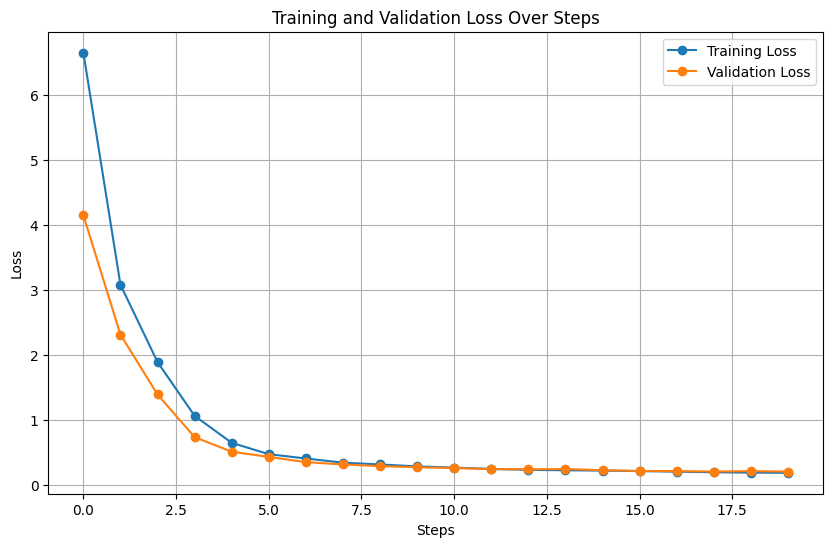

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mean_loss_train, label='Training Loss', marker='o')
plt.plot(mean_loss_test, label='Validation Loss', marker='o')
plt.title("Training and Validation Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

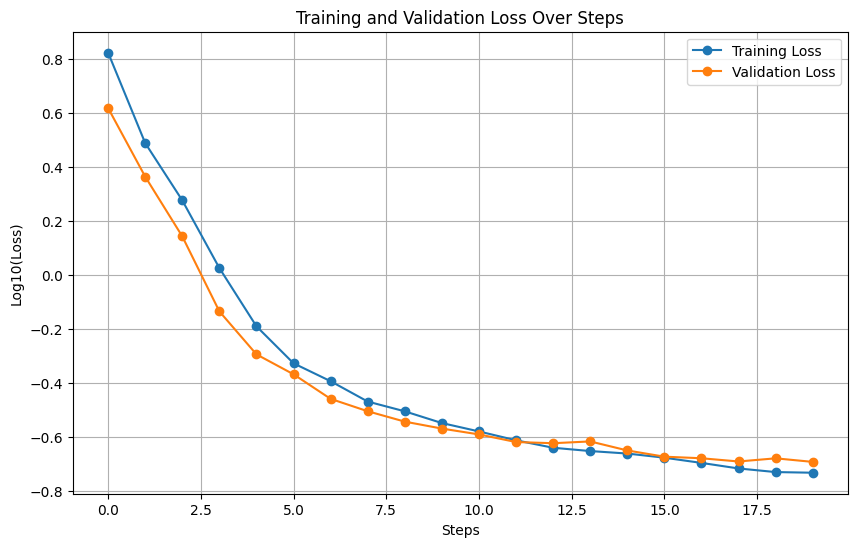

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.log10(mean_loss_train), label='Training Loss', marker='o')
plt.plot(np.log10(mean_loss_test), label='Validation Loss', marker='o')
plt.title("Training and Validation Loss Over Steps")
plt.xlabel("Steps")
plt.ylabel("Log10(Loss)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f'The total Training took: {elapsed_time/60:.2f} minutes')

The total Training took: 104.37 minutes
